In [10]:
# %% [markdown]
# # Twitter Sentiment Analysis using LSTM
# 
# LSTM model for classifying tweets as positive or negative using a balanced Sentiment140 dataset.

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\asokb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
# %%
# Load dataset
data_path = "../data/training.1600000.processed.noemoticon.csv"

df = pd.read_csv(data_path, encoding='latin-1', header=None)
df = df[[0, 5]]
df.columns = ["sentiment", "text"]

# Keep only positive (4) and negative (0)
df = df[df['sentiment'] != 2]
df['sentiment'] = df['sentiment'].map({0: 0, 4: 1})

# Balance the dataset: 25k positive and 25k negative
df_pos = df[df["sentiment"] == 1].sample(25000, random_state=42)
df_neg = df[df["sentiment"] == 0].sample(25000, random_state=42)
df = pd.concat([df_pos, df_neg]).sample(frac=1, random_state=42).reset_index(drop=True)

In [12]:
# %%
# Clean tweets
stop_words = set(stopwords.words('english'))

def preprocess(text):
    text = re.sub(r"http\S+|@\S+|#\S+|[^A-Za-z\s]", "", text)
    text = text.lower().strip()
    tokens = text.split()
    tokens = [t for t in tokens if t not in stop_words]
    return " ".join(tokens)

df["cleaned"] = df["text"].apply(preprocess)

In [13]:
# %%
# Tokenization
max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df["cleaned"])

sequences = tokenizer.texts_to_sequences(df["cleaned"])
X = pad_sequences(sequences, maxlen=max_len, padding="post", truncating="post")
y = df["sentiment"].values

In [14]:
# %%
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# %%
# Build the Bidirectional LSTM model
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

C:\Users\asokb\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [16]:
# %%
# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 471s 747ms/step - accuracy: 0.6681 - loss: 0.5981 - val_accuracy: 0.7566 - val_loss: 0.4974
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 481s 770ms/step - accuracy: 0.7955 - loss: 0.4427 - val_accuracy: 0.7530 - val_loss: 0.5013
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 375s 601ms/step - accuracy: 0.8272 - loss: 0.3881 - val_accuracy: 0.7485 - val_loss: 0.5290
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 466s 734ms/step - accuracy: 0.8581 - loss: 0.3273 - val_accuracy: 0.7445 - val_loss: 0.5718
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 402s 644ms/step - accuracy: 0.8791 - loss: 0.2812 - val_accuracy: 0.7352 - val_loss: 0.6675


In [17]:
# %%
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step - accuracy: 0.7362 - loss: 0.6591
Test Accuracy: 0.7352


313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 65ms/step
              precision    recall  f1-score   support

           0       0.72      0.75      0.74      4972
           1       0.75      0.72      0.73      5028

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     10000



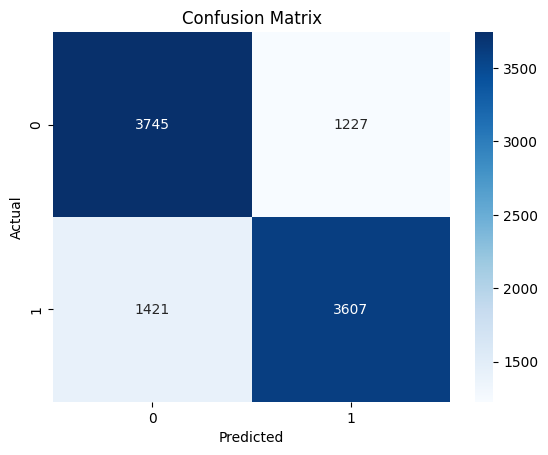

In [18]:
# %%
# Predict and analyze
y_pred = (model.predict(X_test) > 0.5).astype("int32")

print(classification_report(y_test, y_pred, zero_division=0))
conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()